## Social Bots Detection

#### Content  
Part 0: Prepare training dataset  
Part 1: Feature engineering  
Part 2: Build classification model (Xgboost)  
Part 3: Model evaluation  
Part 4: Load data and extract features using pyspark  
Part 5: Prediction on test set  

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from xgboost import plot_importance
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

#### Prepare dataset

In [3]:
# data cleaning has been done before
# load training data
data = pd.read_csv('data/trainset.csv')

print(data.shape)

(77271, 18)


In [11]:
print(data.head())

   Unnamed: 0  default_profile  favourites_count  followers_count  \
0           0            False               628           188419   
1           1            False             11608           180759   
2           2            False                 0            19311   
3           3            False             12798              398   
4           4            False              2135             7125   

   friends_count  geo_enabled         id  listed_count  \
0            857        False   31098240           432   
1            905         True    6892002          1119   
2           1472        False   20083388           675   
3            185        False  385587235             5   
4           4431         True   51240839           160   

   profile_use_background_image  protected  statuses_count  label_human  
0                         False        0.0          117922            1  
1                          True        0.0          176250            1  
2             

#### Feature Engineering

In [13]:
def ratio(a,b):
    ratio = a/(b+0.0000001)
    return ratio

In [14]:
# features calculation
data['follower_friends_ratio'] =data.apply(lambda x: ratio(x.followers_count, x.friends_count), axis = 1)

data['follower_favorite_ratio'] = data.apply(lambda x: ratio(x.followers_count, x.favourites_count), axis = 1)

data['friends_favorite_ratio'] = data.apply(lambda x: ratio(x.friends_count, x.favourites_count), axis = 1)

data['friends_publication_ratio'] = data.apply(lambda x: ratio(x.friends_count, x.statuses_count), axis = 1)

data['followers_publication_ratio'] = data.apply(lambda x: ratio(x.followers_count, x.statuses_count), axis = 1)

data['list_friends_ratio'] = data.apply(lambda x: ratio(x.listed_count, x.friends_count), axis = 1)

In [39]:
data = data.drop(['id','Unnamed: 0'],axis = 1)

In [15]:
data.head()

,Unnamed: 0,default_profile,favourites_count,followers_count,friends_count,geo_enabled,id,listed_count,profile_use_background_image,protected,statuses_count,follower_friends_ratio,follower_favorite_ratio,friends_favorite_ratio,friends_publication_ratio,followers_publication_ratio,list_friends_ratio,label_human
0,0,False,628,188419,857,False,31098240,432,False,0.0,117922,219.858810,3.000303e+02,1.364650e+00,0.007268,1.597827,0.504084,1
1,1,False,11608,180759,905,True,6892002,1119,True,0.0,176250,199.733702,1.557193e+01,7.796347e-02,0.005135,1.025583,1.236464,1
2,2,False,0,19311,1472,False,20083388,675,True,0.0,34918,13.118886,1.931100e+11,1.472000e+10,0.042156,0.553039,0.458560,1
3,3,False,12798,398,185,False,385587235,5,False,0.0,669,2.151351,3.109861e-02,1.445538e-02,0.276532,0.594918,0.027027,1
4,4,False,2135,7125,4431,True,51240839,160,True,0.0,16341,1.607989,3.337237e+00,2.075410e+00,0.271158,0.436020,0.036109,1


#### Build model

In [42]:
# get X,y
y = data['label_human']
X = data.drop(['label_human'], axis=1)

In [43]:
data['label_human'].value_counts()

0    52972
1    24299
Name: label_human, dtype: int64

In [44]:
# split training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
# best tuned model
clf_XGB = XGBClassifier(n_estimators = 100, max_depth=6,learning_rate=0.1, 
                        objective= 'binary:logistic')
clf_XGB.fit(X_train,y_train, early_stopping_rounds=20, 
            eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

#### Evaluation

In [26]:
# get accuracy score
y_pred_xgb = clf_XGB.predict(X_test)
print("XGB Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGB Accuracy: 0.9613717243610482


In [28]:
#get classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     10700
           1       0.93      0.95      0.94      4755

    accuracy                           0.96     15455
   macro avg       0.95      0.96      0.95     15455
weighted avg       0.96      0.96      0.96     15455



Normalized confusion matrix
[[0.96700935 0.03299065]
 [0.05131441 0.94868559]]


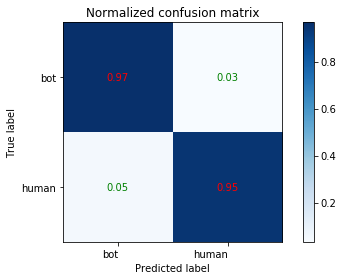

In [30]:
# plot normalized confusion matrix
def plot_confusion_matrix(y_test, predict_test, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, predict_test)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="red" if cm[i, j] > thresh else "green")
    fig.tight_layout()
    return ax

plot_confusion_matrix(y_test, y_pred_xgb, classes=["bot","human"], normalize=True)

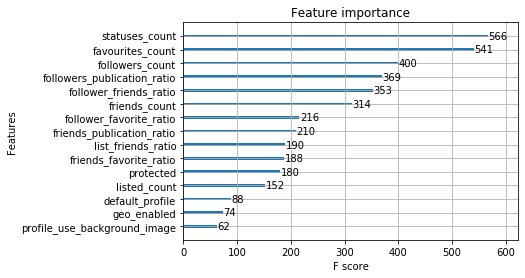

In [46]:
# plot feature importance
plot_importance(clf_XGB)
plt.show()

#### Load data using pyspark

In [5]:
spark = SparkSession \
    .builder \
    .appName("CS5344FinalProject") \
    .config("spark.debug.maxToStringFields", "100") \
    .config("spark.network.timeout", "600s") \
    .config('spark.executor.cores', '3') \
    .config('spark.executor.memory', '2g') \
    .config('spark.driver.memory', '5g') \
    .getOrCreate()

In [6]:
#read data
path_json = "data/tweets_json.json"

raw_data = spark.read.format("json")\
    .option("multiline", "true")\
    .option("header", "true")\
    .option("escape", '"')\
    .load(path_json)

In [7]:
# get features
extracted_features = raw_data.selectExpr('user.default_profile as default_profile', 
                                         'user.favourites_count as favourites_count',
                                         'user.followers_count as followers_count',
                                         'user.friends_count as friends_count',
                                         'user.geo_enabled as geo_enabled',
                                         'user.id as id',
                                         'user.listed_count as listed_count',
                                         'user.profile_use_background_image as profile_use_background_image',
                                         'user.protected as protected',
                                         'user.statuses_count as statuses_count').dropDuplicates(subset=['id'])
data_pre2 = extracted_features.toPandas()
print(extracted_features.count())
extracted_features.show(5)

108622
+---------------+----------------+---------------+-------------+-----------+------------------+------------+----------------------------+---------+--------------+
|default_profile|favourites_count|followers_count|friends_count|geo_enabled|                id|listed_count|profile_use_background_image|protected|statuses_count|
+---------------+----------------+---------------+-------------+-----------+------------------+------------+----------------------------+---------+--------------+
|          false|            3141|            984|          322|      false|         120881626|          29|                        true|    false|          4750|
|          false|            3973|            852|         1221|      false|785810084886568960|          40|                       false|    false|          3414|
|          false|           24790|           1546|         1159|       true|         115368558|         198|                        true|    false|         25846|
|           tru

In [11]:
#end session
spark.stop()

#### Prediction on test set

In [54]:
# deliver features as training 
data_pre2['follower_friends_ratio'] = data_pre2.apply(lambda x: ratio(x.followers_count, x.friends_count), axis = 1)

data_pre2['follower_favorite_ratio'] = data_pre2.apply(lambda x: ratio(x.followers_count, x.favourites_count), axis = 1)

data_pre2['friends_favorite_ratio'] = data_pre2.apply(lambda x: ratio(x.friends_count, x.favourites_count), axis = 1)

data_pre2['friends_publication_ratio'] = data_pre2.apply(lambda x: ratio(x.friends_count, x.statuses_count), axis = 1)

data_pre2['followers_publication_ratio'] = data_pre2.apply(lambda x: ratio(x.followers_count, x.statuses_count), axis = 1)

data_pre2['list_friends_ratio'] = data_pre2.apply(lambda x: ratio(x.listed_count, x.friends_count), axis = 1)


In [55]:
print(data_pre2.shape)
data_pre2.head()

(108622, 16)


,default_profile,favourites_count,followers_count,friends_count,geo_enabled,id,listed_count,profile_use_background_image,protected,statuses_count,follower_friends_ratio,follower_favorite_ratio,friends_favorite_ratio,friends_publication_ratio,followers_publication_ratio,list_friends_ratio
0,False,14347,557,1417,True,46343365,24,True,False,39965,0.393084,0.038823,0.098766,0.035456,0.013937,0.016937
2,True,53631,770,173,False,2510990164,13,True,False,85187,4.450867,0.014357,0.003226,0.002031,0.009039,0.075145
3,True,1484,809,1741,False,997256304296189952,11,True,False,12782,0.464675,0.545148,1.173181,0.136207,0.063292,0.006318
4,False,31297,2236,993,True,128520495,206,True,False,31283,2.251762,0.071445,0.031728,0.031742,0.071477,0.207452
6,False,285,406,859,False,930112543993057280,2,False,False,765,0.472643,1.424561,3.014035,1.122876,0.530719,0.002328


In [56]:
# define input data
df2 = data_pre2[['default_profile', 'favourites_count', 'followers_count',
       'friends_count', 'geo_enabled', 'listed_count',
       'profile_use_background_image', 'protected', 'statuses_count',
       'follower_friends_ratio', 'follower_favorite_ratio',
       'friends_favorite_ratio', 'friends_publication_ratio',
       'followers_publication_ratio', 'list_friends_ratio']]

In [57]:
label_xgb = clf_XGB.predict(df2)
labels = pd.DataFrame(label_xgb)

In [58]:
labels.loc[:,0].value_counts()

1    81021
0    27601
Name: 0, dtype: int64

In [74]:
# merge and output
id = data_pre2['id']
id = pd.DataFrame(id)
labels_final = id.join(labels)
labels_final = labels_final.drop_duplicates()
labels_final = labels_final.rename(columns={0: 'label'})
labels_final.to_csv('data/label.csv', index=False)